# Simplified House Price Prediction Model

This notebook builds a simple machine learning model to predict house prices using the zameen.com dataset. We'll go through the following steps:

1. Data Loading and Exploration
2. Data Preprocessing
3. Model Building and Evaluation
4. Visualization of Results
5. Saving the Model for Web Application

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Load and Explore the Dataset

In [2]:

df = pd.read_csv('zameen_complete_dataset.csv')

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (50882, 14)


,city,city_id,link,property_type,location,province,price_text,bedrooms,baths,size_text,size_marla,size_sqft,price,scrape_date
0,Islamabad,3,https://www.zameen.com/Property/islamabad_i-8_...,House,I-8,Islamabad,10.75 Crore,6,6,14 Marla,14.0,3150.0,107500000,5/18/2025
1,Islamabad,3,https://www.zameen.com/Property/g_13_g-13_4_bu...,House,G-13/4,G-13,12 Crore,6,6,14 Marla,14.0,3150.0,120000000,5/18/2025
2,Islamabad,3,https://www.zameen.com/Property/i_8_i-8_4_high...,House,I-8/4,I-8,13.95 Crore,6,6,14 Marla,14.0,3150.0,139500000,5/18/2025
3,Islamabad,3,https://www.zameen.com/Property/d_12_d-12_2_10...,House,D-12/2,D-12,12 Crore,6,7,10 Marla,10.0,2250.0,120000000,5/18/2025
4,Islamabad,3,https://www.zameen.com/Property/d_12_d-12_1_on...,House,D-12/1,D-12,4.4 Crore,4,4,4 Marla,4.0,900.0,44000000,5/18/2025


In [3]:
df.dtypes

city              object
city_id            int64
link              object
property_type     object
location          object
province          object
price_text        object
bedrooms           int64
baths              int64
size_text         object
size_marla       float64
size_sqft        float64
price              int64
scrape_date       object
dtype: object

In [4]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

,Missing Values,Percentage


In [5]:
df.describe()

,city_id,bedrooms,baths,size_marla,size_sqft,price
count,50882.000000,50882.000000,50882.000000,5.088200e+04,5.088200e+04,5.088200e+04
mean,5.613891,4.553162,4.836504,9.279608e+01,2.087912e+04,7.496849e+07
std,11.795947,1.681147,1.617710,1.239216e+04,2.788236e+06,1.177483e+08
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,9.000000e+00
25%,1.000000,3.000000,4.000000,5.000000e+00,1.125000e+03,2.200000e+07
50%,2.000000,5.000000,5.000000,1.000000e+01,2.250000e+03,4.000000e+07
75%,3.000000,5.000000,6.000000,2.000000e+01,4.500000e+03,8.150000e+07
max,41.000000,11.000000,10.000000,1.975300e+06,4.444425e+08,4.000000e+09


## 3. Data Preprocessing

In [6]:
columns_to_drop = ['city_id', 'link', 'price_text', 'size_text', 'size_sqft','scrape_date','province']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

df = df[df['price'] > 0]
df = df[df['size_marla'] > 0] 

df = df.dropna(subset=['price', 'property_type', 'location', 'city', 'bedrooms', 'baths', 'size_marla'])


print("Dataset shape after preprocessing:", df.shape)

Dataset shape after preprocessing: (50872, 7)


In [7]:
df['price_per_marla'] = df['price'] / df['size_marla']

In [8]:
Q1 = df['price_per_marla'].quantile(0.25)
Q3 = df['price_per_marla'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price_per_marla'] >= lower_bound) & (df['price_per_marla'] <= upper_bound)]

print(f"Dataset shape after removing outliers: {df.shape}")

Dataset shape after removing outliers: (46860, 8)


In [9]:
df.head()

,city,property_type,location,bedrooms,baths,size_marla,price,price_per_marla
0,Islamabad,House,I-8,6,6,14.0,107500000,7.678571e+06
1,Islamabad,House,G-13/4,6,6,14.0,120000000,8.571429e+06
5,Islamabad,House,DHA Defence Phase 5,4,3,5.0,33000000,6.600000e+06
6,Islamabad,House,Bahria Enclave - Sector C1,5,5,10.0,55000000,5.500000e+06
7,Islamabad,House,Bahria Enclave - Sector N,3,4,5.0,23500000,4.700000e+06


## 4. Save Unique Locations and Cities for Frontend

In [10]:
locations = df['location'].unique().tolist()
cities = df['city'].unique().tolist()

os.makedirs('static/data', exist_ok=True)


with open('static/data/locations.txt', 'w') as f:
    for location in locations:
        f.write(f"{location}\n")

with open('static/data/cities.txt', 'w') as f:
    for city in cities:
        f.write(f"{city}\n")

print(f"Saved {len(locations)} unique locations and {len(cities)} unique cities for frontend")

Saved 2602 unique locations and 5 unique cities for frontend


## 5. Data Visualization

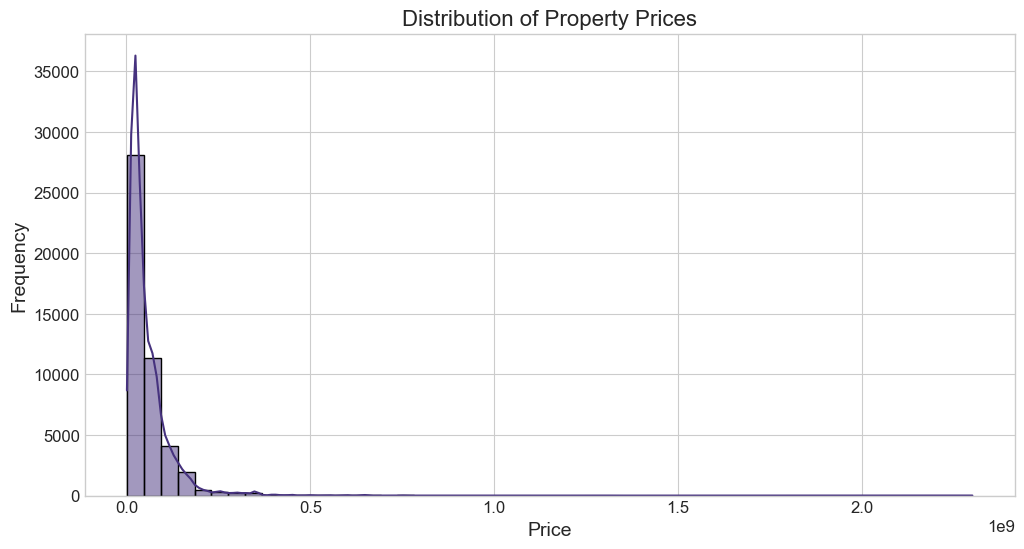

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribution of Property Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

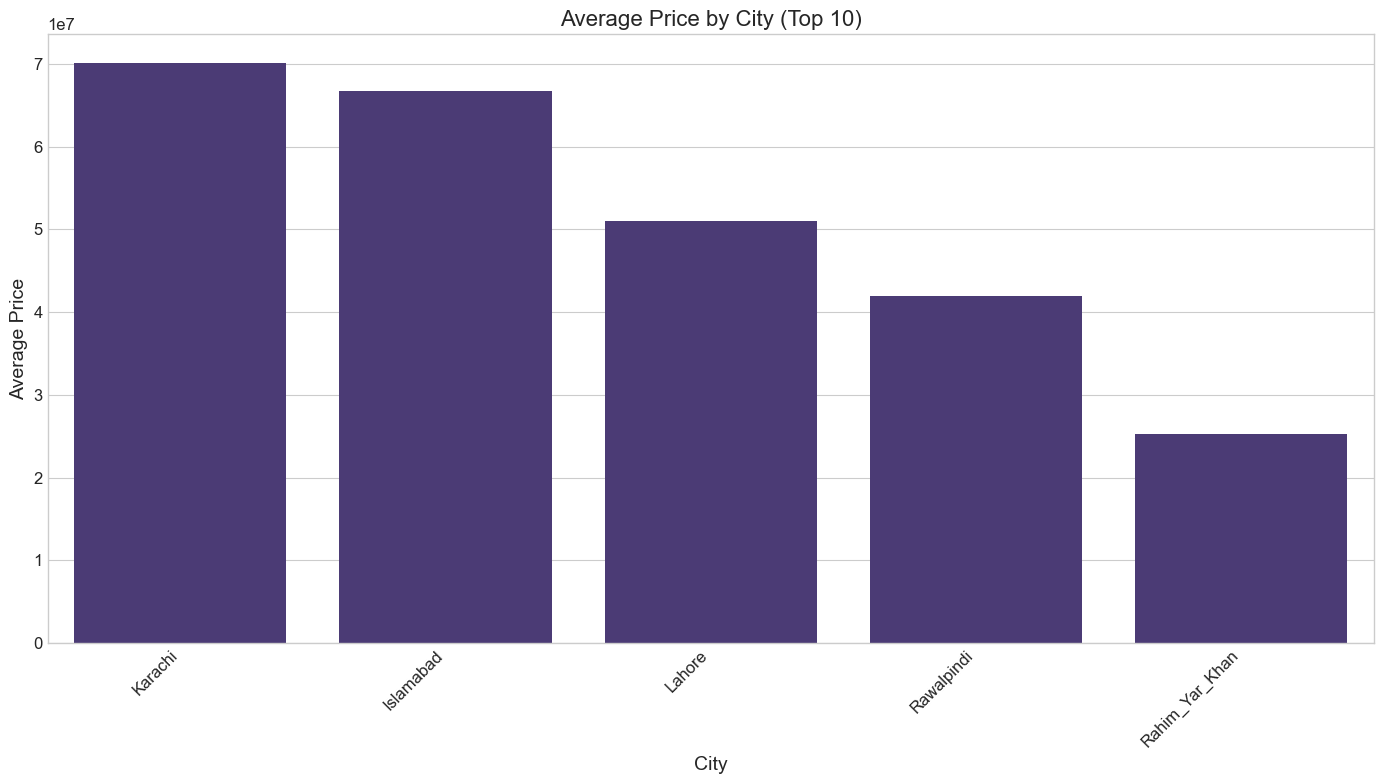

In [12]:
plt.figure(figsize=(14, 8))
city_price = df.groupby('city')['price'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=city_price.index, y=city_price.values)
plt.title('Average Price by City (Top 10)', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('City', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.tight_layout()
plt.show()

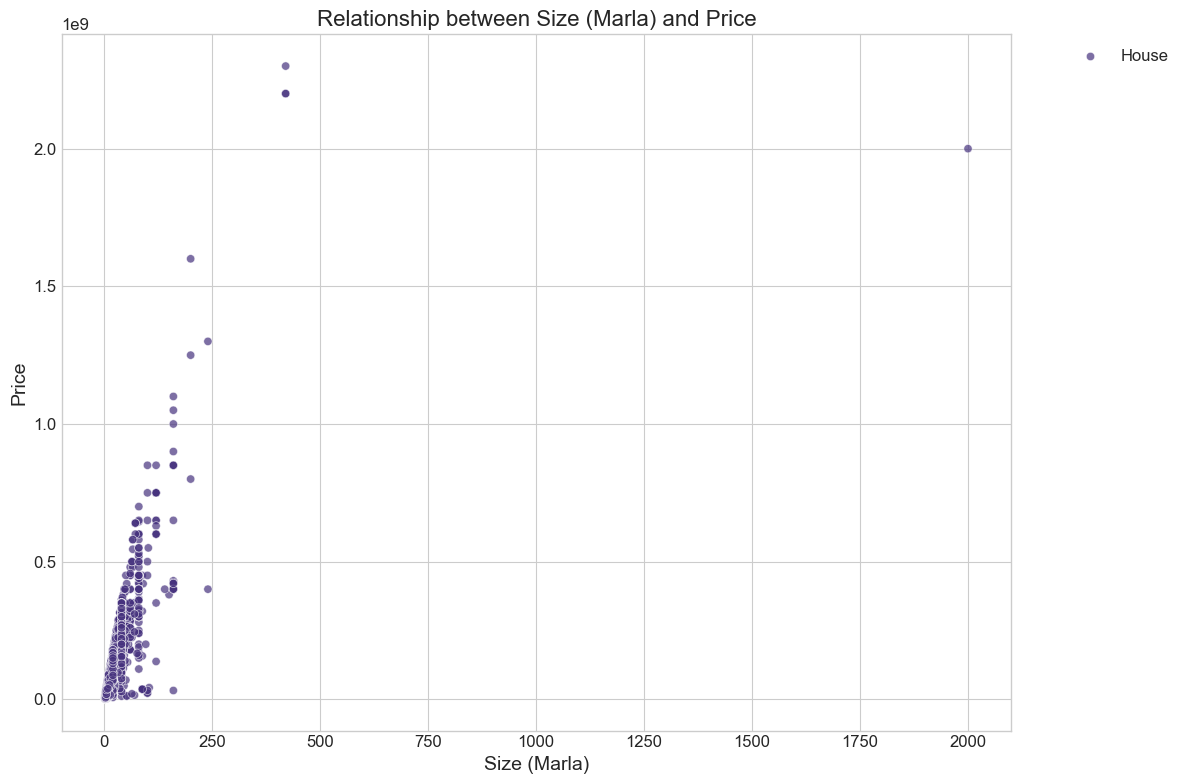

In [13]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='size_marla', y='price', hue='property_type', data=df.sample(21000), alpha=0.7)
plt.title('Relationship between Size (Marla) and Price', fontsize=16)
plt.xlabel('Size (Marla)', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 6. Prepare Data for Modeling

In [14]:
X = df[['property_type', 'location', 'city', 'baths', 'bedrooms', 'size_marla']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (37488, 6)
Testing set shape: (9372, 6)


In [15]:

categorical_features = ['property_type', 'location', 'city']
numerical_features = ['baths', 'bedrooms', 'size_marla']


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ])

## 7. Model Building and Evaluation

In [16]:

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Bagging Regressor': BaggingRegressor(n_estimators=50, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}


def evaluate_model(model, X_train, X_test, y_train, y_test, preprocessor, model_name):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    

    print(f"Training {model_name}...")
    pipeline.fit(X_train, y_train)
    

    print(f"Making predictions with {model_name}...")
    y_pred = pipeline.predict(X_test)
    

    y_pred = np.maximum(y_pred, 0)
    

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    

    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    

    accuracy = max(0, 100 - mape)
    
    print(f"\n{model_name} Evaluation:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    
    return {
        'model': pipeline,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'accuracy': accuracy,
        'y_pred': y_pred
    }

In [17]:
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test, preprocessor, name)


Evaluating Linear Regression...
Training Linear Regression...
Making predictions with Linear Regression...

Linear Regression Evaluation:
R² Score: 0.8560
RMSE: 23931533.13
MAE: 11527371.33
MAPE: 22.93%
Accuracy: 77.07%

Evaluating Decision Tree...
Training Decision Tree...
Making predictions with Decision Tree...

Decision Tree Evaluation:
R² Score: 0.8645
RMSE: 23218487.85
MAE: 8837513.72
MAPE: 15.09%
Accuracy: 84.91%

Evaluating Random Forest...
Training Random Forest...
Making predictions with Random Forest...

Random Forest Evaluation:
R² Score: 0.8829
RMSE: 21583147.91
MAE: 8859820.33
MAPE: 15.27%
Accuracy: 84.73%

Evaluating Gradient Boosting...
Training Gradient Boosting...
Making predictions with Gradient Boosting...

Gradient Boosting Evaluation:
R² Score: 0.8309
RMSE: 25937838.96
MAE: 13479520.59
MAPE: 30.77%
Accuracy: 69.23%

Evaluating Bagging Regressor...
Training Bagging Regressor...
Making predictions with Bagging Regressor...

Bagging Regressor Evaluation:
R² Score: 0

## 8. Compare Model Performance

In [18]:

model_names = list(results.keys())
r2_scores = [results[name]['r2'] for name in model_names]
accuracy_scores = [results[name]['accuracy'] for name in model_names]


comparison_df = pd.DataFrame({
    'Model': model_names,
    'R² Score': [results[name]['r2'] for name in model_names],
    'RMSE': [results[name]['rmse'] for name in model_names],
    'MAE': [results[name]['mae'] for name in model_names],
    'MAPE (%)': [results[name]['mape'] for name in model_names],
    'Accuracy (%)': [results[name]['accuracy'] for name in model_names]
})

comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False).reset_index(drop=True)
comparison_df

,Model,R² Score,RMSE,MAE,MAPE (%),Accuracy (%)
0,Decision Tree,0.864480,2.321849e+07,8.837514e+06,15.089451,84.910549
1,Random Forest,0.882898,2.158315e+07,8.859820e+06,15.272769,84.727231
2,Bagging Regressor,0.883792,2.150061e+07,8.883557e+06,15.298012,84.701988
3,Linear Regression,0.856029,2.393153e+07,1.152737e+07,22.927325,77.072675
4,XGBoost,0.816738,2.700033e+07,1.165821e+07,24.198504,75.801496
5,Gradient Boosting,0.830877,2.593784e+07,1.347952e+07,30.769824,69.230176


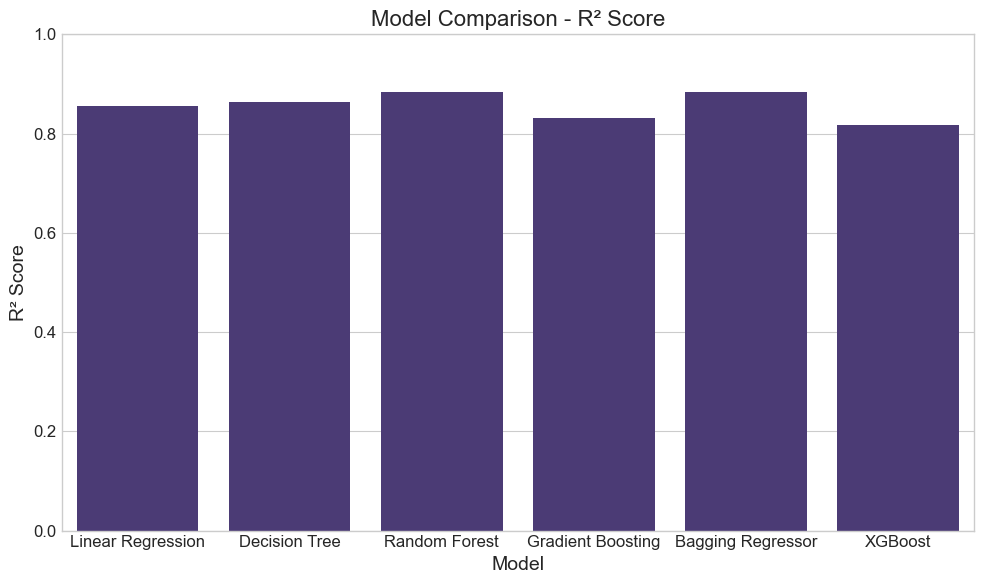

In [19]:

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=r2_scores)
plt.title('Model Comparison - R² Score', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.ylim(0, 1)
plt.tight_layout()


os.makedirs('static/images', exist_ok=True)
plt.savefig('static/images/r2_comparison.png')
plt.show()

## 9. Select the Best Model

In [20]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"R² Score: {results[best_model_name]['r2']:.4f}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.2f}%")


Best Model: Decision Tree
R² Score: 0.8645
Accuracy: 84.91%


## 10. Visualize Actual vs Predicted Prices

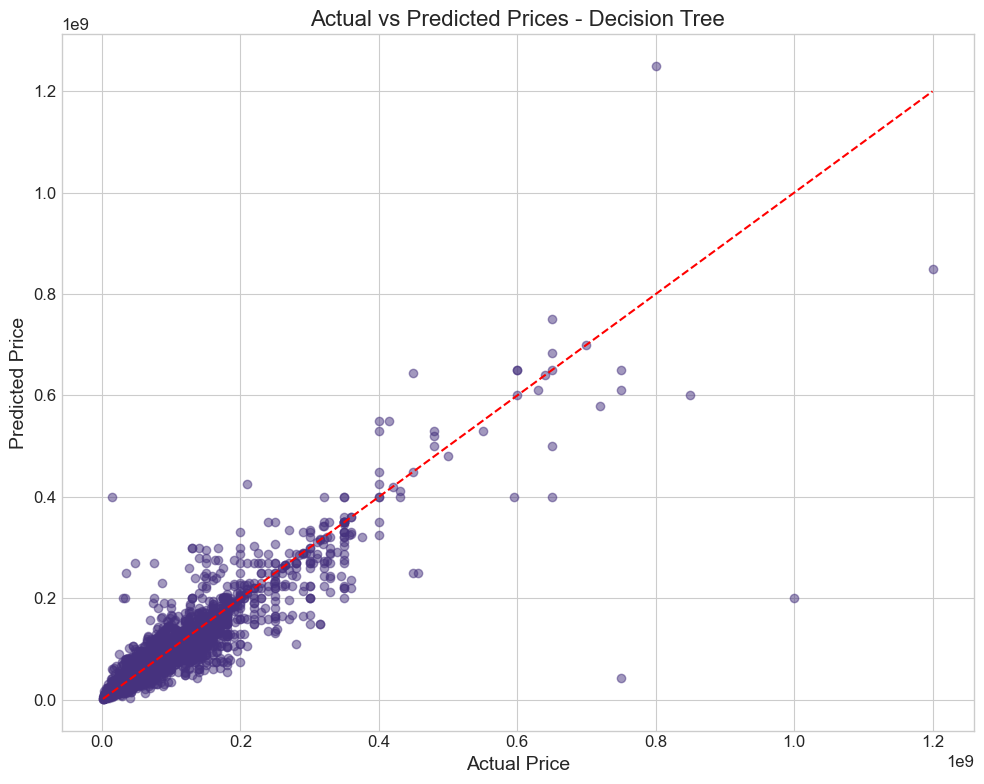

In [21]:
y_pred = results[best_model_name]['y_pred']

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Actual vs Predicted Prices - {best_model_name}', fontsize=16)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.tight_layout()
plt.savefig('static/images/actual_vs_predicted.png')
plt.show()

In [22]:

error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Percentage_Error': (y_test - y_pred) / y_test * 100
})


error_df.head()

,Actual,Predicted,Error,Percentage_Error
16378,270000000,1.975000e+08,7.250000e+07,26.851852
1876,125000000,1.220723e+08,2.927703e+06,2.342162
10959,34000000,3.100000e+07,3.000000e+06,8.823529
48182,41500000,4.430168e+07,-2.801681e+06,-6.751038
2606,90000000,1.275000e+08,-3.750000e+07,-41.666667


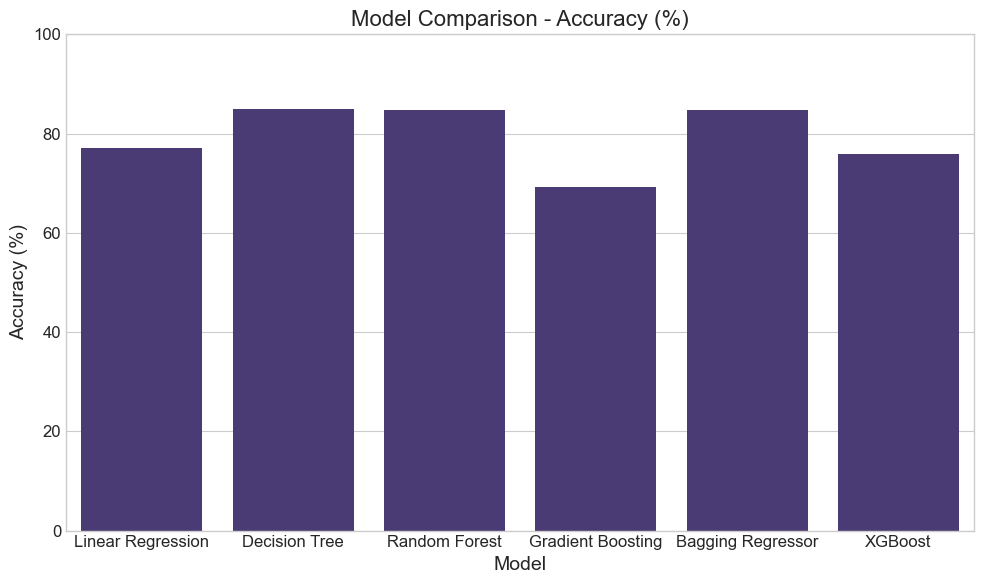

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores)
plt.title('Model Comparison - Accuracy (%)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('static/images/accuracy_comparison.png')
plt.show()

## 11. Save the Best Model

In [25]:
with open('house_price_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model saved as 'house_price_model.pkl'")

model_info = {
    'model_name': best_model_name,
    'r2_score': results[best_model_name]['r2'],
    'accuracy': results[best_model_name]['accuracy'],
    'features': list(X.columns)
}

with open('model_info.pkl', 'wb') as file:
    pickle.dump(model_info, file)

print("Model information saved as 'model_info.pkl'")

Model saved as 'house_price_model.pkl'
Model information saved as 'model_info.pkl'


## 12. Test the Model with Sample Input

In [26]:

sample_input = pd.DataFrame({
    'property_type': ['House'],
    'location': ['DHA Phase 5'],
    'city': ['Lahore'],
    'baths': [3],
    'bedrooms': [4],
    'size_marla': [10]  # 10 Marla
})


sample_prediction = best_model.predict(sample_input)
sample_prediction = np.maximum(sample_prediction, 0)  # Ensure no negative predictions

print(f"Sample Input:\n{sample_input}\n")
print(f"Predicted Price: PKR {sample_prediction[0]:,.2f}")

Sample Input:
  property_type     location    city  baths  bedrooms  size_marla
0         House  DHA Phase 5  Lahore      3         4          10

Predicted Price: PKR 63,333,333.33
